In [5]:
!pip install -q keras-ocr python-Levenshtein wordninja tensorflow roboflow --quiet seaborn matplotlib scikit-learn

In [7]:
import keras_ocr
import matplotlib.pyplot as plt
import Levenshtein
import wordninja
from roboflow import Roboflow
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
from collections import defaultdict
import pandas as pd

In [8]:
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /Users/yaseminozkut/.keras-ocr/craft_mlt_25k.h5
Looking for /Users/yaseminozkut/.keras-ocr/crnn_kurapan.h5


In [ ]:
rf = Roboflow(api_key="Your API Key")
project = rf.workspace("product-detection-4zkyw").project("market-products-detection")
dataset = project.version(4).download("yolov8")

In [9]:
HOME = os.getcwd()
print(HOME)

/Users/yaseminozkut/Dev/Internship/Smart-Kitchen/OCR


In [12]:
product_dict = {"mehl", "wasser", "water", "volvic", "evian", "kaffee", "caffe", "coffee", "cappucino", "espresso", "lavazza", "nescafe", "latte", "macchiato", "frappe", "milch", "milk", "tea", "tee", "lord nelson"}

In [14]:
#Closest word for the word
def find_closest_word(word, dictionary):
  closest_word = None
  min_distance = float('inf')  # Set an initial large value for minimum distance

  for dict_word in dictionary:
    distance = Levenshtein.distance(word, dict_word)
    if len(word) <= 3:
      return "other"
    if distance < min_distance:
      min_distance = distance
      closest_word = dict_word

  # If the minimum distance is greater than a threshold (e.g., 2), consider it "other"
  threshold = 2
  if min_distance > threshold:
    return "other"
  else:
    return closest_word

In [15]:
def find_class_name(classID):
  name = ""
  if(classID == "0"):
    name = "Kaffee/Coffee"
  elif(classID == "1"):
    name = "Mehl/Flour"
  elif(classID == "2"):
    name = "Milch/Milk"
  elif(classID == "4"):
    name = "Tee/Tea"
  elif(classID == "5"):
    name = "Wasser-Water"
  return name

In [16]:
def find_real_classes(img):
  classes = []
  img = img.rsplit('.jpg', 1)[0] + '.txt'
  img = img.replace('images' ,'labels')
  #print(img)
  with open(img, "r") as file:
      for line in file:
          words = line.strip().split()  # Split the line into words
          first_word = words[0]
          if(find_class_name(first_word) not in classes):
              classes.append(find_class_name(first_word))
  return classes

In [17]:
def convert_class_name(word):
    if (word == 'mehl'):
        word2 = 'Mehl/Flour'
    elif (word == 'wasser'):
        word2 = 'Wasser-Water'
    elif (word == 'water'):
        word2 = 'Wasser-Water'
    elif (word == 'evian'):
        word2 = 'Wasser-Water'
    elif (word == 'volvic'):
        word2 = 'Wasser-Water'
    elif (word == 'kaffee'):
        word2 = 'Kaffee/Coffee'
    elif (word == 'caffe'):
        word2 = 'Kaffee/Coffee'
    elif word == 'coffee':
        word2 = 'Kaffee/Coffee'
    elif word == 'cappucino':
        word2 = 'Kaffee/Coffee'
    elif word == 'espresso':
        word2 = 'Kaffee/Coffee'
    elif word == 'lavazza':
        word2 = 'Kaffee/Coffee'
    elif word == 'nescafe':
        word2 = 'Kaffee/Coffee'
    elif word == 'latte':
        word2 = 'Kaffee/Coffee'
    elif word == 'macchiato':
        word2 = 'Kaffee/Coffee'
    elif word == 'frappe':
        word2 = 'Kaffee/Coffee'
    elif word == 'milch':
        word2 = 'Milch/Milk'
    elif word == 'milk':
        word2 = 'Milch/Milk'
    elif word == 'tea':
        word2 = 'Tee/Tea'   
    elif word == 'tee':
        word2 = 'Tee/Tea'
    elif word == 'lord nelson':
        word2 = 'Tee/Tea'
    return word2

In [18]:
image_folder = '/Users/yaseminozkut/Dev/Internship/Smart-Kitchen/OCR/Market-Products-Detection-4/test/images'
image_paths = [os.path.join(image_folder, filename) for filename in os.listdir(image_folder)]
predicted_classes = []

# Determine the chunk size (10% of total images)
chunk_size = len(image_paths) // 10
num_chunks = 10
selected_image_paths = []
for i in range(num_chunks):
    start_idx = i * chunk_size
    end_idx = start_idx + chunk_size
    chunk_image_paths = image_paths[start_idx:end_idx]
    selected_image_paths.append(chunk_image_paths)

    images = [keras_ocr.tools.read(img) for img in chunk_image_paths]
    prediction_groups = pipeline.recognize(images)
    word_list = []
    for prediction in prediction_groups:
        predict_list = []
        for p in prediction:
            predict_list.append(p[0])
        word_list.append(predict_list)

    new_list = []
    print(word_list)
    
    for prediction_groups in word_list:
        predicted_class = []
        for word in prediction_groups:
            if len(word) <= 2:
                #predicted_class.append("other")
                #print(f"{word} -> other")
                continue
            elif word == "rewe":
                #predicted_class.append("other")
                #print(f"{word} -> other")
                continue
            elif word in product_dict:
                predicted_class.append(word)
                #print(word, "->", word)
                #new_list.append(word)
            else:
                matching_product = next((product for product in product_dict if product in word), None)
                if matching_product:
                    predicted_class.append(matching_product)
                    #print(word, "->", matching_product)
                    #new_list.append(word)
                else:
                    matching_product = next((item for item in product_dict if item in word), None)
                    if matching_product:
                        #print(word, "->", matching_product)
                        predicted_class.append(matching_product)
                        #new_list.append(word)
                        break

                    else:
                        closest = find_closest_word(word, product_dict)
                        if(closest != "other"):
                            predicted_class.append(closest)
                            #print(word, "->", closest)

                        else:
                            separated_words = wordninja.split(word)
                            for sep in separated_words:
                                sep_closest = find_closest_word(sep, product_dict)
                                if(sep_closest != "other"):
                                    #print(word, "->", sep_closest)
                                    predicted_class.append(sep_closest)
        predicted_classes.append(predicted_class)
        print("-----------end of image--------------")

3/3 [==============================] - 4s 1s/step
[['rewe', 'cappuccin'], ['lavazza', 'mase', 'efl', 'caffe', 'espresso'], ['sohan', 'oie', 'l', 'cchlk', 'cic'], [], ['fealr', 'reas', 'did', 'bd', 'arla', 'arl', 'len', 'l', 'ath', 'slsce', 'io', 'bio', 'eile', 'welde', 'lleer', 'frische', 'mitlchee', 'frische', 'ioll', 'woll', 'mileh', 'milch', 'fett', 'den', 'la', 'ti', 'dineeteel', 'talie', 'rtle', 'suut', 'le', 'f', 't', 'tl'], [], ['ce', 'te', 'sss', 'sser', 'gold', 'nas', 'puder', 'lehe', 'ter', 'las', 'jcreteig'], ['tnlos', 'tencfef', 'ttag', 'rllin', 'nortae', 'me'], ['hohb', 'a', 'muha', 'huler', 'bio', 'blo', 'pene', 'roggen', 'vollkommehl', 'ca', 'ocael', 'no', 'ooog', 'on', 'rot', 'uinule'], ['s', '', '', 'e', 's', '', 's']]
-----------end of image--------------
-----------end of image--------------
-----------end of image--------------
-----------end of image--------------
-----------end of image--------------
-----------end of image--------------
-----------end of image---

In [19]:
real_classes = []
for chunk in selected_image_paths:
    for img in chunk:
        real_classes.append(find_real_classes(img))

In [20]:
predicted_classes2 = []
for predict in predicted_classes:
    predict2 = []
    for word in predict:
        converted = convert_class_name(word)
        predict2.append(converted)
    predicted_classes2.append(predict2)

print(predicted_classes2)

[['Kaffee/Coffee'], ['Kaffee/Coffee', 'Kaffee/Coffee', 'Kaffee/Coffee'], ['Mehl/Flour'], [], ['Mehl/Flour', 'Tee/Tea', 'Milch/Milk', 'Tee/Tea', 'Milch/Milk', 'Tee/Tea', 'Milch/Milk', 'Milch/Milk', 'Tee/Tea', 'Tee/Tea'], [], ['Wasser-Water', 'Tee/Tea'], ['Tee/Tea'], ['Mehl/Flour', 'Tee/Tea', 'Mehl/Flour'], [], ['Kaffee/Coffee', 'Kaffee/Coffee', 'Kaffee/Coffee', 'Milch/Milk', 'Kaffee/Coffee', 'Kaffee/Coffee', 'Kaffee/Coffee', 'Kaffee/Coffee', 'Kaffee/Coffee', 'Kaffee/Coffee', 'Tee/Tea'], ['Milch/Milk', 'Milch/Milk'], ['Kaffee/Coffee'], [], ['Wasser-Water', 'Wasser-Water'], ['Wasser-Water', 'Wasser-Water'], ['Kaffee/Coffee', 'Tee/Tea'], [], [], ['Wasser-Water'], ['Mehl/Flour'], ['Kaffee/Coffee', 'Kaffee/Coffee', 'Kaffee/Coffee', 'Kaffee/Coffee'], ['Kaffee/Coffee', 'Tee/Tea', 'Tee/Tea'], [], ['Kaffee/Coffee', 'Tee/Tea'], [], [], [], ['Milch/Milk', 'Tee/Tea', 'Tee/Tea'], ['Mehl/Flour', 'Mehl/Flour'], ['Mehl/Flour', 'Mehl/Flour'], ['Milch/Milk'], ['Tee/Tea', 'Kaffee/Coffee', 'Kaffee/Coffee',

In [21]:
unique_predict = []
for predict in predicted_classes2:
    unique_classes = set(predict)
    unique_classes_list = list(unique_classes)
    unique_predict.append(unique_classes_list)

print(unique_predict)

[['Kaffee/Coffee'], ['Kaffee/Coffee'], ['Mehl/Flour'], [], ['Milch/Milk', 'Tee/Tea', 'Mehl/Flour'], [], ['Wasser-Water', 'Tee/Tea'], ['Tee/Tea'], ['Tee/Tea', 'Mehl/Flour'], [], ['Tee/Tea', 'Milch/Milk', 'Kaffee/Coffee'], ['Milch/Milk'], ['Kaffee/Coffee'], [], ['Wasser-Water'], ['Wasser-Water'], ['Tee/Tea', 'Kaffee/Coffee'], [], [], ['Wasser-Water'], ['Mehl/Flour'], ['Kaffee/Coffee'], ['Tee/Tea', 'Kaffee/Coffee'], [], ['Tee/Tea', 'Kaffee/Coffee'], [], [], [], ['Tee/Tea', 'Milch/Milk'], ['Mehl/Flour'], ['Mehl/Flour'], ['Milch/Milk'], ['Tee/Tea', 'Kaffee/Coffee'], ['Milch/Milk'], [], ['Wasser-Water'], ['Tee/Tea'], [], ['Wasser-Water', 'Tee/Tea', 'Mehl/Flour'], ['Mehl/Flour'], [], ['Kaffee/Coffee'], ['Milch/Milk'], [], [], [], ['Wasser-Water', 'Kaffee/Coffee'], ['Mehl/Flour'], ['Tee/Tea', 'Milch/Milk'], ['Tee/Tea'], ['Tee/Tea'], ['Milch/Milk', 'Kaffee/Coffee'], ['Tee/Tea', 'Mehl/Flour'], ['Wasser-Water'], [], [], [], ['Milch/Milk'], ['Wasser-Water'], ['Milch/Milk'], [], ['Mehl/Flour'], ['M

In [22]:
for uniq in unique_predict:
    if(len(uniq) == 0):
        uniq.append("Nothing Predicted")

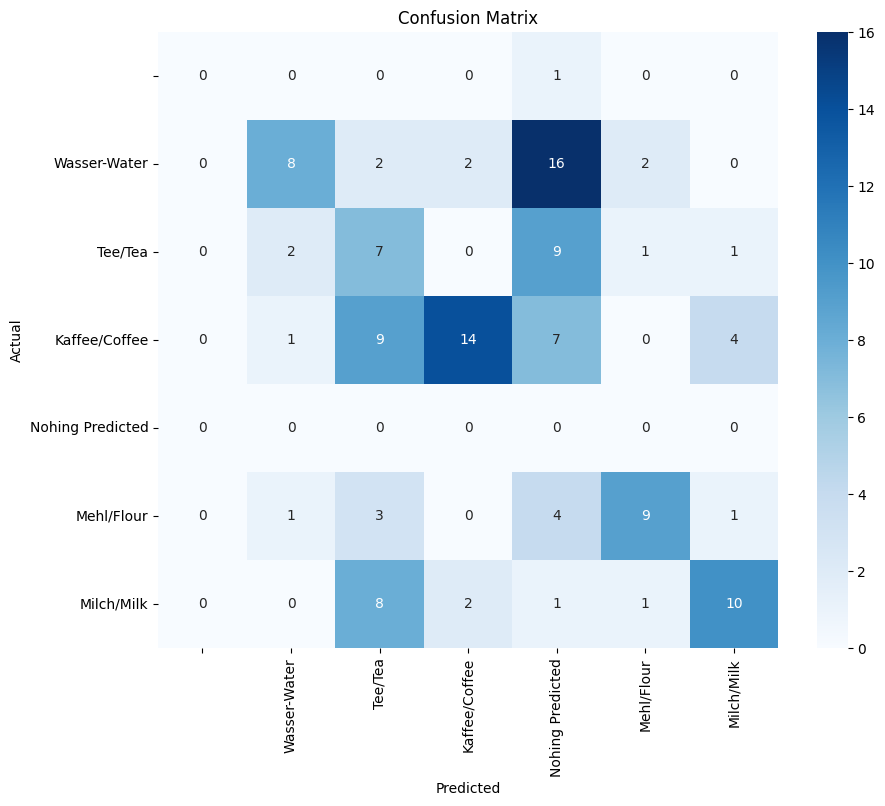

In [26]:
confusion_dict = defaultdict(int)
real_classes_flat = [item for sublist in real_classes for item in sublist]
predicted_classes_flat = [item for sublist in unique_predict for item in sublist]
for i in range(len(real_classes)):
    real_class = real_classes[i]
    predicted_class = unique_predict[i]
    
    for pred_class in predicted_class:
        if(len(real_class)!= 0):
            confusion_dict[(real_class[0], pred_class)] += 1

# Create a confusion matrix using the dictionary values
confusion_matrix_data = []
for actual_class in unique_classes:
    row = [confusion_dict[(actual_class, predicted_class)] for predicted_class in unique_classes]
    confusion_matrix_data.append(row)

unique_classes = list(set(real_classes_flat + predicted_classes_flat))

# Convert confusion matrix data to a DataFrame for Seaborn visualization
confusion_df = pd.DataFrame(confusion_matrix_data, index=unique_classes, columns=unique_classes)

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
